# Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2 as cv

# Reading in the Data

In [2]:
# read in the files

age_path = os.path.join('Data','AgeImages')
age_rows = []
for filename in os.listdir(age_path):
    values = filename.split('_')
    if len(values) == 2:
        age = values[0]
        age_rows.append([filename,age])

df = pd.DataFrame(age_rows,columns=['filename','age'])
df = df.astype({'age':int})

# Exploratory Data Analysis

33486

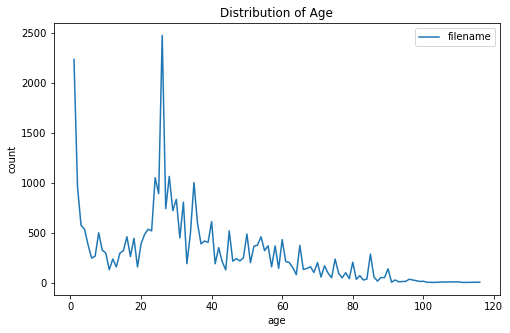

In [3]:
df.groupby('age').count().plot(title='Distribution of Age',ylabel='count',figsize=(8,5))
len(df)

## Experimenting with Methods to Deal with Imbalanced Data

In [5]:
# undersampling experiment (didn't work too well)

'''nMax = 500
df = df.groupby('age',as_index=False).apply(lambda x: x.sample(n=min(nMax, len(x))))
df.groupby('age').count().plot(title='distribution of age',ylabel='count',figsize=(8,5))
'''
# manually adding weights based off previous results
weights_col = []
for i in df['age']:
    # over-represented data = lower weight
    # under-represented data = higher weight
    if i <=2:
        weights_col.append(0.5)
    elif i <= 20:
        weights_col.append(1.5)
    elif i <= 40:
        weights_col.append(0.75)
    elif i <= 60:
        weights_col.append(1)
    else:
        weights_col.append(1.25)
df['weights'] = np.array(weights_col).astype('float16')
df

,filename,age,weights
0,100_1.jpg,100,1.25
1,100_10.jpg,100,1.25
2,100_11.jpg,100,1.25
3,100_12.jpg,100,1.25
4,100_13.jpg,100,1.25
...,...,...,...
33481,9_95.jpg,9,1.50
33482,9_96.jpg,9,1.50
33483,9_97.jpg,9,1.50
33484,9_98.jpg,9,1.50


## Train, Test, Validation Split

In [6]:
# train test split

# training = 90% of the data
df_train=df.sample(frac=0.9,random_state=1)
df_other=df.drop(df_train.index)

# validation = 10%
df_val=df_other.sample(frac=1.0,random_state=1)
#df_test=df_other.drop(df_val.index)
df_val.head()

,filename,age,weights
15843,31_253.jpg,31,0.75
11514,27_24.jpg,27,0.75
1940,17_111.jpg,17,1.50
6903,23_64.jpg,23,0.75
27378,58_291.jpg,58,1.00


## Creating ImageDataGenerators to Flow Data into the Model

In [7]:
# Create the image data generators
train_image_generator = ImageDataGenerator(rescale=(1.0/255),
                                           horizontal_flip=True)
val_image_generator = ImageDataGenerator(rescale=(1.0/255))

train_data_gen = train_image_generator.flow_from_dataframe(
    df_train,
    directory=age_path,
    x_col="filename",
    y_col=["age"],
    weight_col="weights",
    target_size=(200,200),
    color_mode="rgb",
    batch_size=64,
    class_mode="raw") # raw class_mode because age column contains the actual target values for training

validation_data_gen = val_image_generator.flow_from_dataframe(
    df_val,
    directory=age_path,
    x_col="filename",
    y_col=["age"],
    target_size=(200,200),
    color_mode="rgb",
    batch_size=64,
    class_mode="raw")

Found 30137 validated image filenames.
Found 3349 validated image filenames.



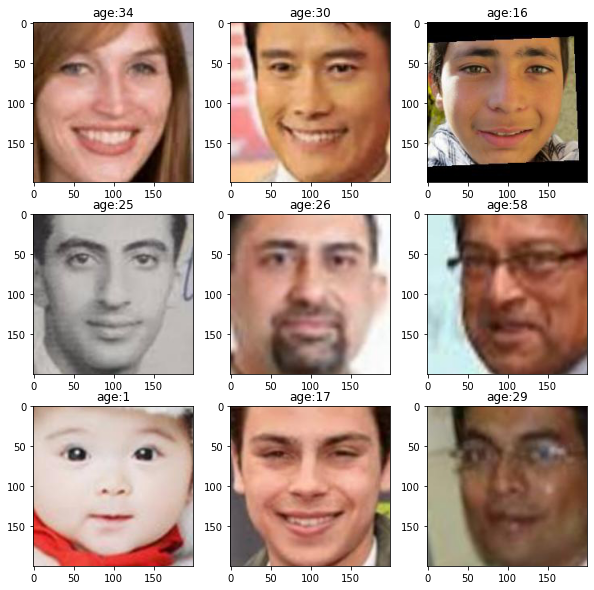

In [8]:
imgs, labels, weights = next(train_data_gen)
plt.figure(figsize=(10,10))
for i in range(1,10):
    plt.subplot(3,3,i)
    plt.imshow(imgs[i])
    plt.title('age:' + str(labels[i,0]))

# Creating the Model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 198, 198, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 99, 99, 16)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 99, 99, 16)        64        
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 97, 97, 16)        2320      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 48, 48, 16)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 48, 48, 16)        64        
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 46, 46, 32)       

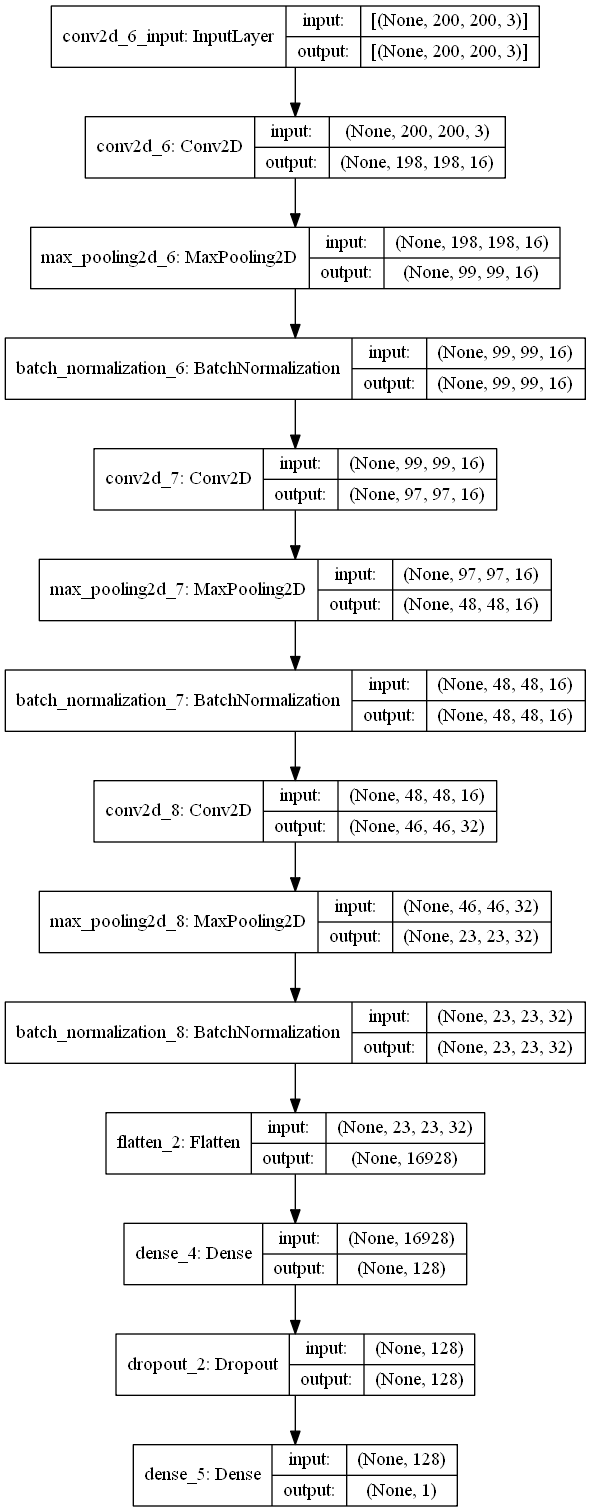

In [21]:
# create the model
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(200,200,3)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='relu'))

model.compile(optimizer='adam',
              loss=tf.keras.losses.mae)

model.summary()

# save an image of the model architechture
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, to_file='age_model_img.png')

In [12]:
history = model.fit(x=train_data_gen,
                    epochs=30,
                    steps_per_epoch=None,
                    validation_data=validation_data_gen,
                    validation_steps=None)

Epoch 1/30
471/471 [==============================] - 199s 421ms/step - loss: 11.7045 - val_loss: 11.3298
Epoch 2/30
471/471 [==============================] - 40s 84ms/step - loss: 9.4048 - val_loss: 8.1087
Epoch 3/30
471/471 [==============================] - 37s 79ms/step - loss: 8.6579 - val_loss: 6.7811
Epoch 4/30
471/471 [==============================] - 38s 80ms/step - loss: 8.1826 - val_loss: 7.2781
Epoch 5/30
471/471 [==============================] - 37s 79ms/step - loss: 7.7388 - val_loss: 7.7766
Epoch 6/30
471/471 [==============================] - 40s 85ms/step - loss: 7.5015 - val_loss: 10.5570
Epoch 7/30
471/471 [==============================] - 37s 78ms/step - loss: 7.2425 - val_loss: 6.3467
Epoch 8/30
471/471 [==============================] - 36s 76ms/step - loss: 7.0644 - val_loss: 6.4176
Epoch 9/30
471/471 [==============================] - 36s 77ms/step - loss: 6.9754 - val_loss: 6.0056
Epoch 10/30
471/471 [==============================] - 36s 77ms/step - loss: 

# Visualizing the Results

In [59]:
results = model.evaluate(test_data_gen)

79/79 [==============================] - 34s 435ms/step - loss: 7.3460


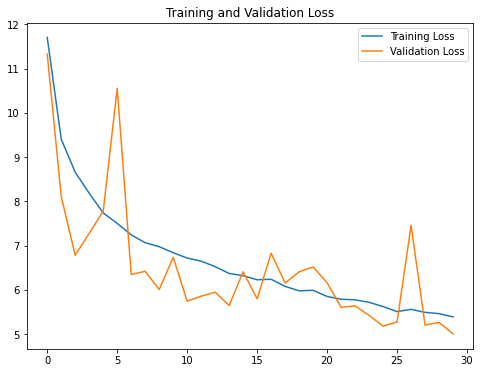

In [14]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
# 30 is the number of epochs
x = range(30)
plt.figure(figsize=(8,6))
plt.plot(x, train_loss, label='Training Loss')
plt.plot(x, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')

plt.show()

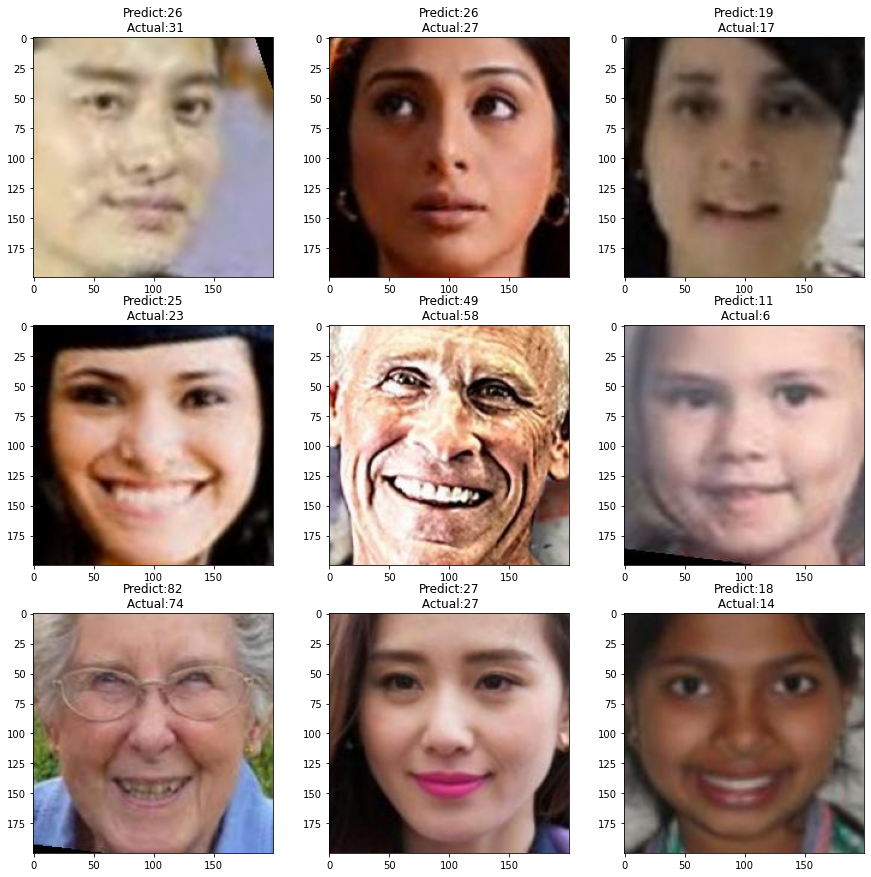

In [15]:
imgs_path = df_val['filename'][0:9]
plt.figure(figsize=(15,15))
i = 1
for filename in imgs_path:
    img = cv.imread(os.path.join(age_path,filename))
    img = cv.resize(img,(200,200))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = img/255.0
    img = np.reshape(img,(200,200,3))
    results = np.round(model.predict(np.array([img]))).astype('int32')
    plt.subplot(3,3,i)
    plt.imshow(img, cmap='gray')
    plt.title('Predict:' + str(results[0][0]) + '\n Actual:' + str(df_val.loc[df['filename']==filename]['age'].values[0]))
    i += 1

## Saving the Model

In [20]:
# save the model
model.save(os.path.join('Models','age_model_5.00'))

INFO:tensorflow:Assets written to: Models\age_model_5.00\assets


INFO:tensorflow:Assets written to: Models\age_model_5.00\assets


### Predicting on Custom Images

In [ ]:
# loading the saved model
loaded_model = tf.keras.models.load_model(os.path.join('Models','age_model_5.00'))

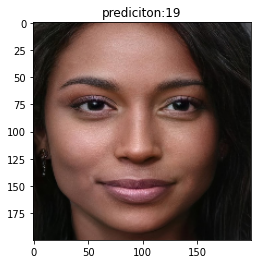

In [26]:
def predict_custom(path):
    # formatting the image correctly to fit into input layer
    my_img = cv.imread(my_img_path)
    my_img = cv.resize(my_img,(200,200))
    my_img = cv.cvtColor(my_img, cv.COLOR_BGR2RGB)
    my_img = my_img/255.0

    # predicting
    my_img = np.reshape(my_img,(200,200,3))
    my_predict = np.round(loaded_model.predict(np.array([my_img]))).astype('int32')
    plt.imshow(my_img)
    plt.title('prediciton:' + str(my_predict[0][0]))
    
my_img_path = os.path.join('Data','CustomTest','1.jpg')
predict_custom(my_img_path)

### Saving as TFLite for Mobile Use

In [19]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('age_model_5.00.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\prath\AppData\Local\Temp\tmpiccf5jw3\assets
